In [51]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
import sys; sys.path.append('..')
import sys; sys.path.append('../preetum')
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from os.path import join
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
import colorcet as cc
from ipdb import set_trace
import pandas as pd
from p_tqdm import p_map, p_umap # parallel map
from tqdm.auto import tqdm
from functools import partial
from multiprocessing import RawArray, Pool
pmap = p_map

import PIL
from io import BytesIO
import PIL.Image
from tqdm.auto import tqdm
import umap
from sklearn.manifold import TSNE

from plot_utils import stacksimple
from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from cifarclass import cifar100_classes

from pncommon import * # my stuff
from jupyter_preproc import smoothen, probs_to_softacc
rng = np.random.default_rng(2)

def probs_to_softacc(probs):
    return np.array([probs[i, yi, :] for i, yi in enumerate(ytest)]).mean(0)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [101]:
def stacksimple(i, x, prof, dataset, classes, topk=5, ax=None):
    """
        i: index of image in dataset
        x: x-axis points
        prof: profile (NUM_LABELS, len(x))
        datset: image dataset
        classes: mapping labels to class names
        topk: number of "main" labels, for the legend.
    """
    img, true_label = dataset.__getitem__(i)
    areas = prof.sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals

    label_names = [classes[idx] if j < topk else '_nolegend_' for j, idx in enumerate(ind)]
    if ax is None:
        f, ax = plt.subplots(figsize=(9, 6), dpi=70)
        # f, ax = plt.subplots(figsize=(3, 2))
    
    # colors = sns.color_palette('muted')[:topk] # first k colors: by palette
    # cm = sns.color_palette('rainbow', as_cmap=True)
    # fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    # colors += [fix_alpha(cm(v)) for v in np.linspace(0, 1,len(ind)-topk)]
    
    cp = 0.3 # fraction of color space to take up with topk
    c1, c2 = np.linspace(0, cp, topk, endpoint=False), np.linspace(cp, 1, len(ind)-topk)
    fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    cm = sns.color_palette('husl', as_cmap=True)
    colors = [cm(v) for v in c1] + [fix_alpha(cm(v)) for v in c2]
    
    stacks = ax.stackplot(x, prof[ind], labels=label_names, colors=colors)
    
    for s in stacks: #stacks[topk:]:
        s.set_edgecolor((0,0,0, 0.2))
        s.set_linewidth(0.2)

    for s in stacks[:topk]:
        s.set_edgecolor((0,0,0, 0.7))
        s.set_linewidth(0.3)
    
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = "$\\bf{" + labels[0].upper().replace('_', '\ ') + "}$"
    labels = list(map(lambda e : e.replace('_', ' ').capitalize()[:25], labels))
    handles, labels = handles[::-1], labels[::-1] # flip order
    
    ax.legend(handles, labels, ncol=2, bbox_to_anchor=(0.1, -0.2), loc='lower left', borderaxespad=0, frameon=False)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, 1)
    # ax.set_axis_off()
    sns.despine()
    
    # ax2 = ax.inset_axes([1.01, 0.5, 0.5, 0.5], aspect='equal')
    # ax2.set_axis_off()
    # ax2.imshow(img)
    
    return ax

def compare_plot(i, d1, d2):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    for j, (ax, dat) in enumerate(zip([ax1, ax2], [d1, d2])):
        
        res = smoothen(dat, xkey, t, i)
        xx = res[f'{xkey}_grid']
        yy = res[f'{t}_smooth']
        
        stacksimple(i, xx, yy, dataset, classes, ax=ax, topk=4)
        #hack 
        if j == 0:
            ax.set_title(f'Const LR, {model} on Image {i}')
        elif j == 1:
            ax.set_title(f'Cos Anneal, {model} on Image {i}')

    xlim = (max(ax1.get_xlim()[0], ax2.get_xlim()[0]), min(ax1.get_xlim()[1], ax2.get_xlim()[1]))
    ylim = (max(ax1.get_ylim()[0], ax2.get_ylim()[0]), min(ax1.get_ylim()[1], ax2.get_ylim()[1]))
    
    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)
    
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
        
    
    ax3.imshow(dataset.__getitem__(i)[0])
    ax3.set_axis_off()
    plt.show()

In [56]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

label_mapping=cifar100_classes
classes = list(label_mapping.values())
NUM_SAMPLES = 10000

print("loading data")

all_group_paths = ['../processed/cifar100/clip_new/group2.pkl', '../processed/cifar100/constant_lr/group2.pkl']
            # '../processed/cifar100/resnets/group2.pkl']

all_groups = list(map(load_pickle, tqdm(all_group_paths)))
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")

## Simple repackaging
g0 = all_groups[0]
g1 = all_groups[1]

grouped0 = {k : g0[name][k] for k in g0[name].keys()}
grouped1 = {k : g1[name][k] for k in g1[name].keys()}
# groups = list(grouped.keys())
print('groups0: ', list(grouped0))
print('groups1: ', list(grouped1))

model = 'ClipViTB32'
G1 = grouped0[model]
G2 = grouped1[model]




loading data


  0%|          | 0/2 [00:00<?, ?it/s]

done
loading dataset
Files already downloaded and verified
done
groups0:  ['ClipViTB32', 'ClipViTB16']
groups1:  ['Densenet121', 'ClipViTB16', 'Resnet18', 'ClipViTB32', 'Densenet121-pretrained', 'Resnet18-pretrained']


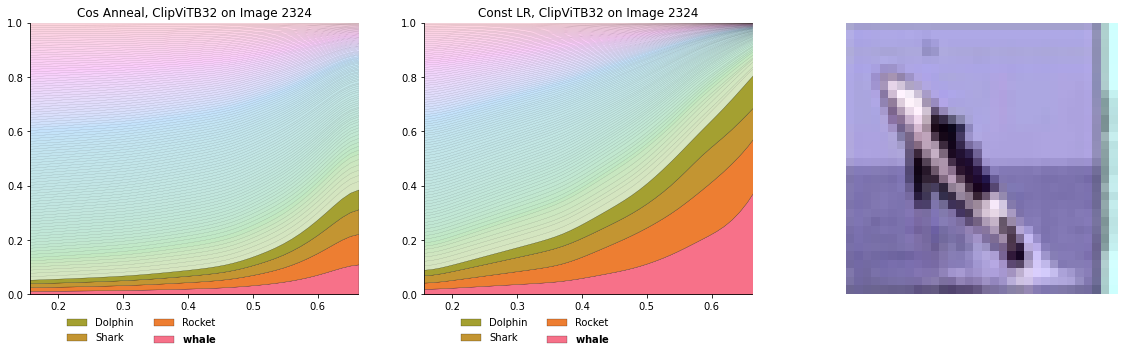

In [87]:
i = 2324
compare_plot(i, G1, G2)

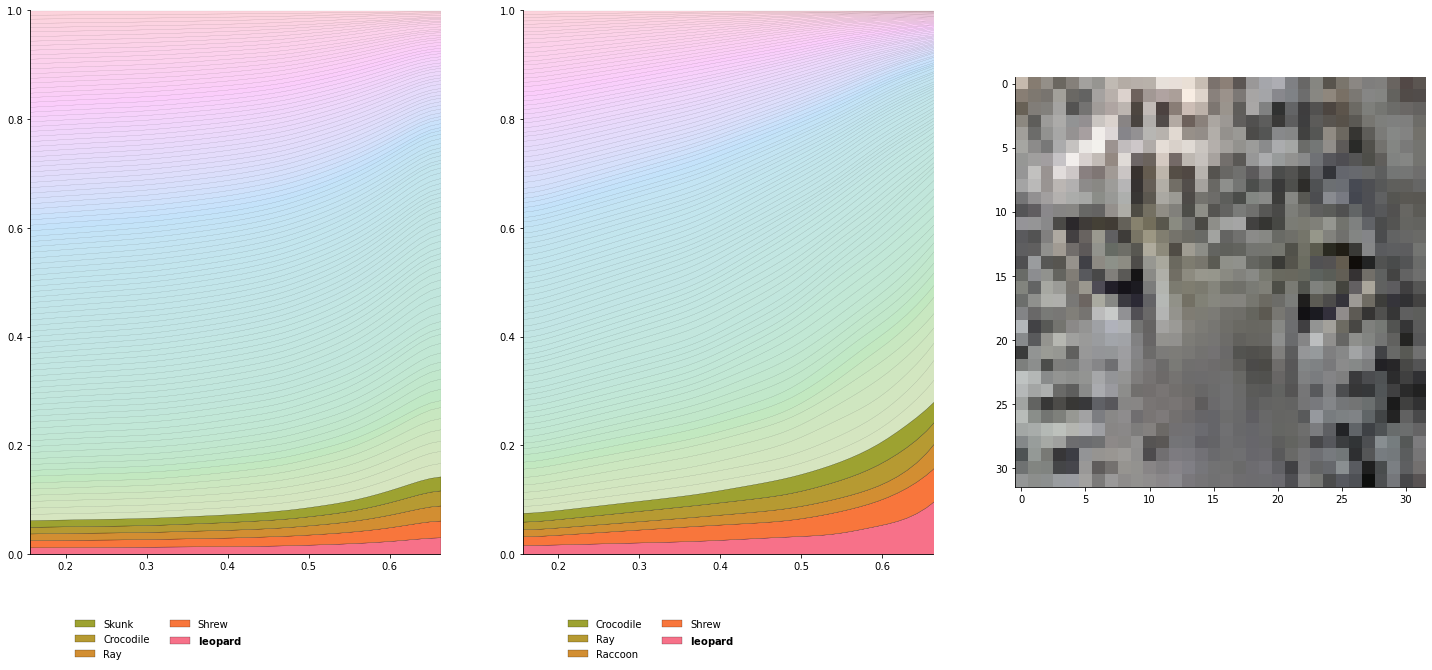

In [85]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)


# Resnet

In [88]:
name = "CIFAR100_test"
train_set = "CIFAR100_train"

label_mapping=cifar100_classes
classes = list(label_mapping.values())
NUM_SAMPLES = 10000

print("loading data")

all_group_paths = ['../processed/cifar100/resnets/group2.pkl', '../processed/cifar100/constant_lr/group2.pkl']
            # '../processed/cifar100/resnets/group2.pkl']

all_groups = list(map(load_pickle, tqdm(all_group_paths)))
print("done")

print("loading dataset")
dataset = get_dataset('data', name)
ytest = np.array(dataset.targets)
print("done")

## Simple repackaging
g0 = all_groups[0]
g1 = all_groups[1]

grouped0 = {k : g0[name][k] for k in g0[name].keys()}
grouped1 = {k : g1[name][k] for k in g1[name].keys()}
# groups = list(grouped.keys())
print('groups0: ', list(grouped0))
print('groups1: ', list(grouped1))

model = 'Resnet18'
G1 = grouped0[model]
G2 = grouped1[model]

cos_anneal = G1
constant_lr = G2

loading data


  0%|          | 0/2 [00:00<?, ?it/s]

done
loading dataset
Files already downloaded and verified
done
groups0:  ['Resnet18-pretrained', 'Densenet121-pretrained', 'Resnet18', 'Densenet121']
groups1:  ['Densenet121', 'ClipViTB16', 'Resnet18', 'ClipViTB32', 'Densenet121-pretrained', 'Resnet18-pretrained']


# Different images

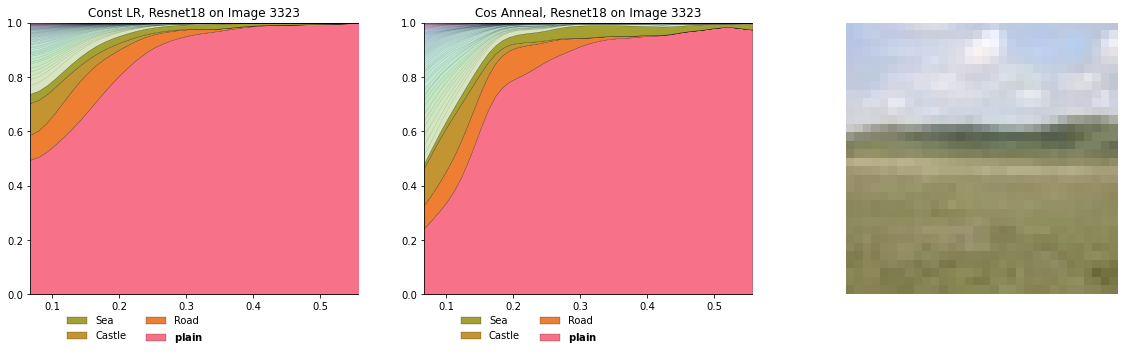

In [104]:

i = np.random.choice(10000)
compare_plot(i, G1, G2)


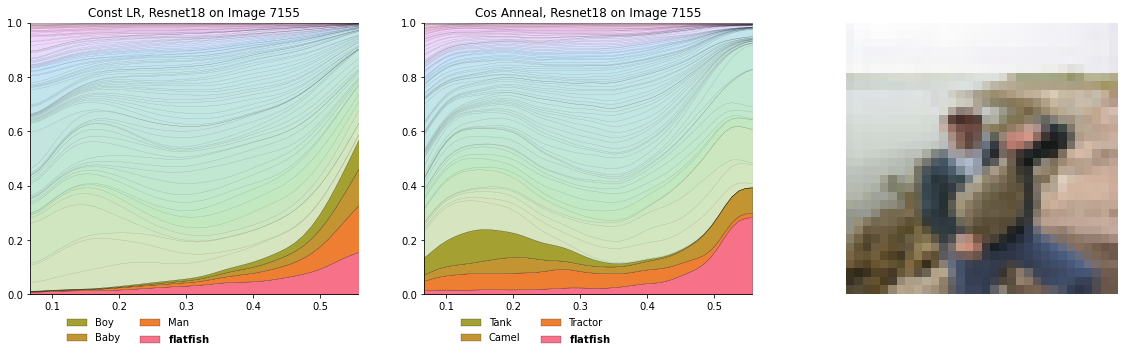

In [109]:

i = np.random.choice(10000)
compare_plot(i, G1, G2)



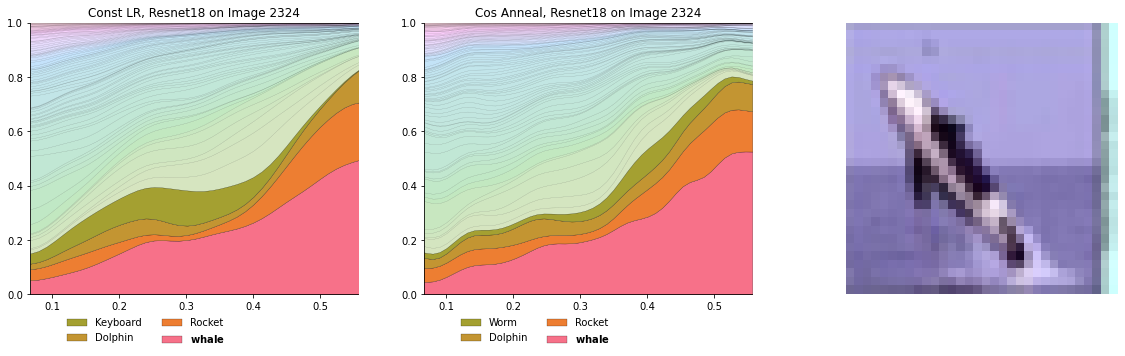

In [107]:

i = 2324
compare_plot(i, G1, G2)



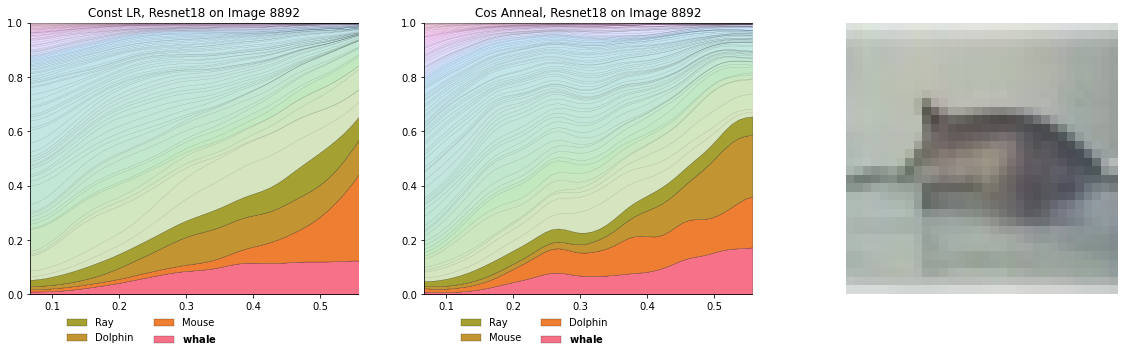

In [110]:
i = np.random.choice(10000)
compare_plot(i, G1, G2)

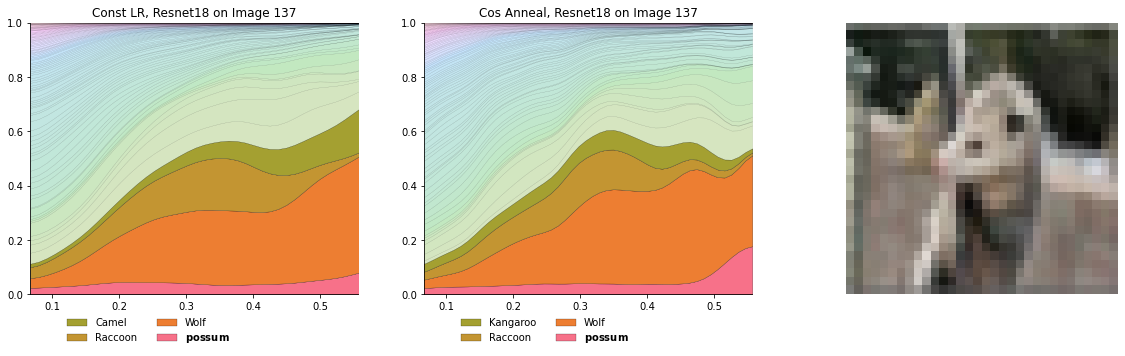

In [111]:
i = np.random.choice(10000)
compare_plot(i, G1, G2)

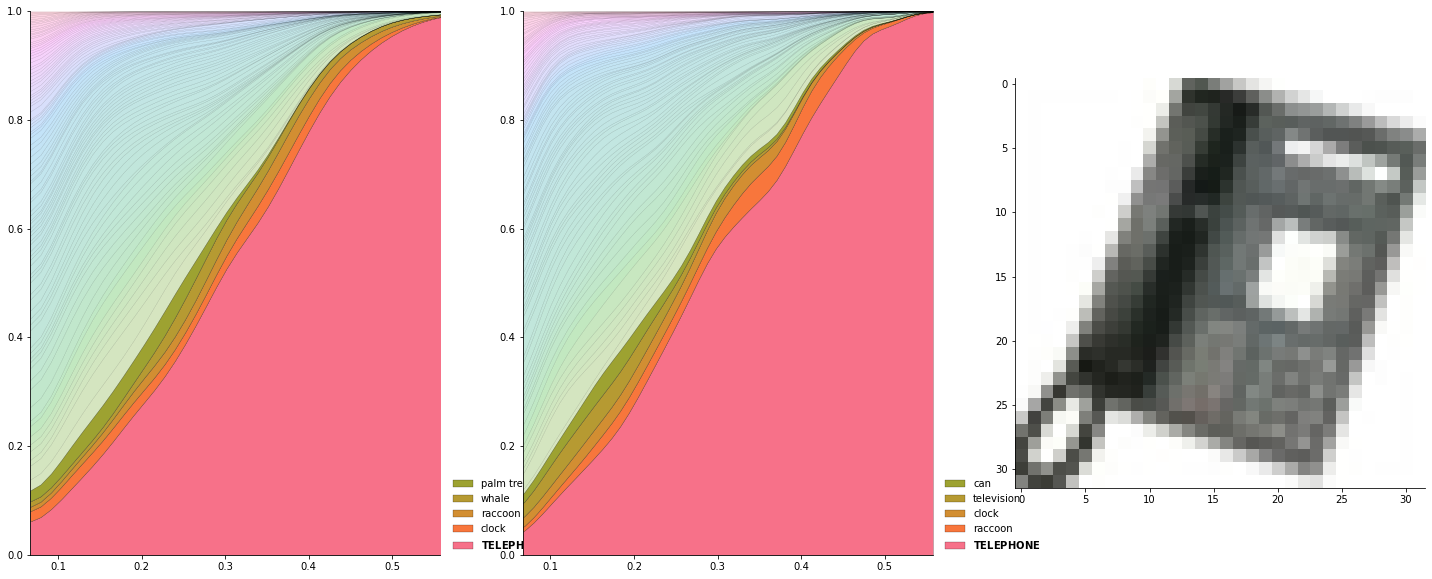

In [24]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)a


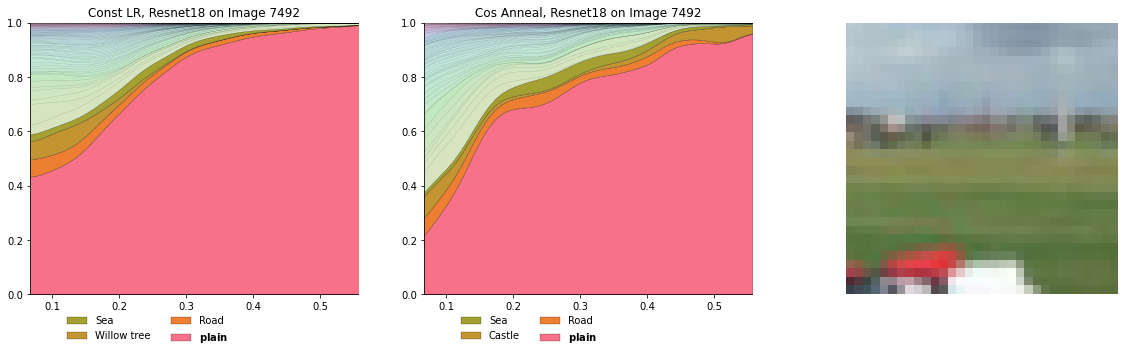

In [112]:
i = np.random.choice(10000)
compare_plot(i, G1, G2)

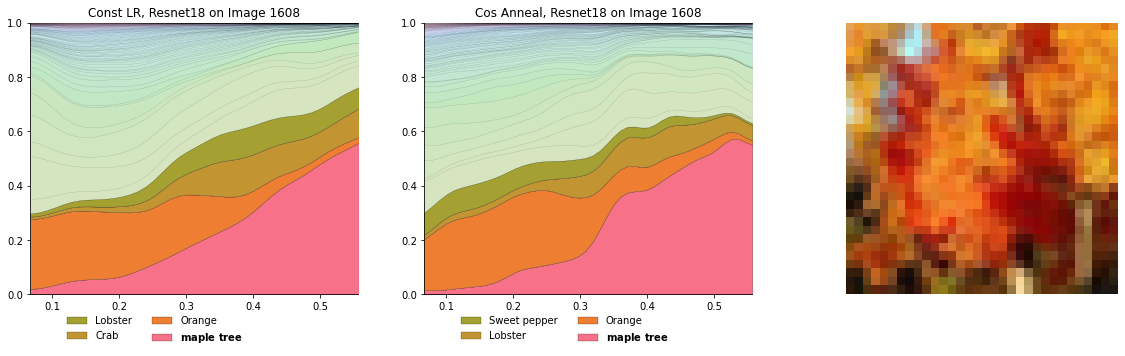

In [113]:
i = np.random.choice(10000)
compare_plot(i, G1, G2)

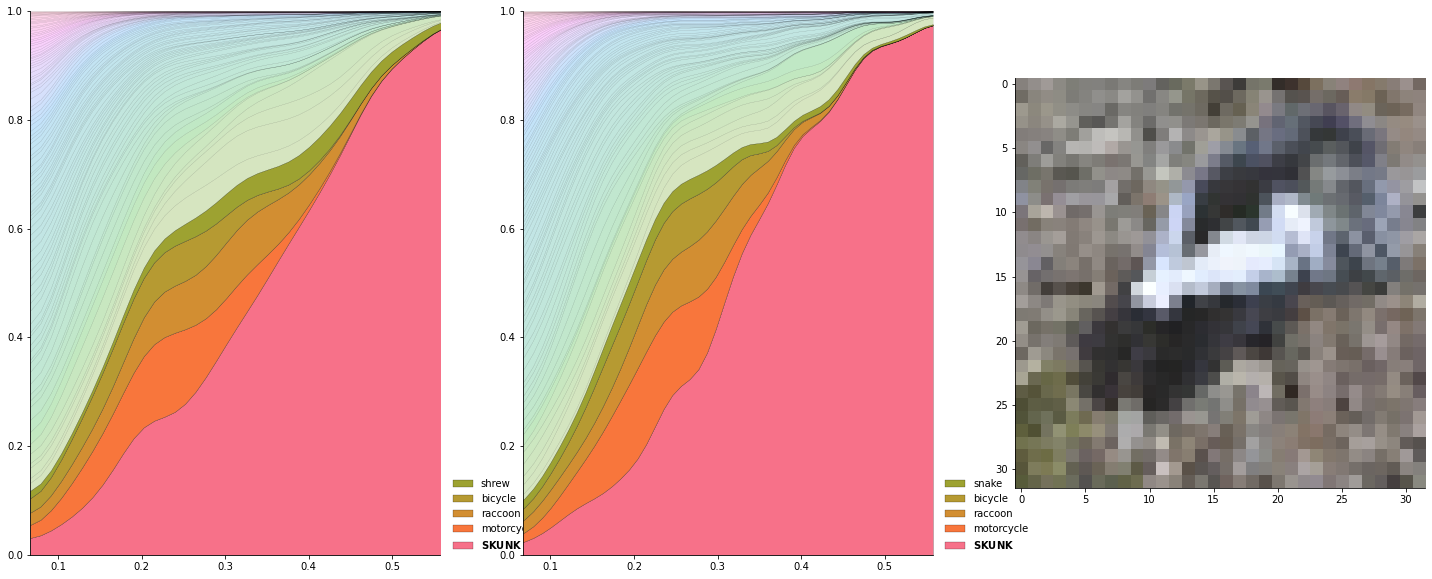

In [43]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)

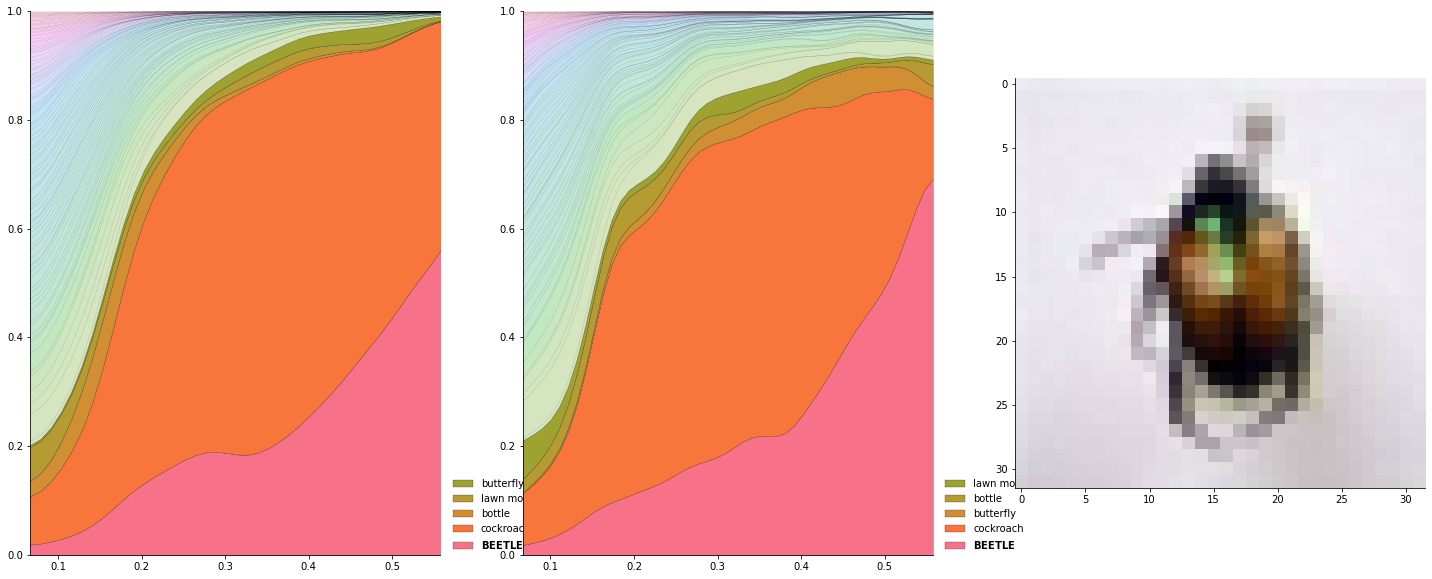

In [44]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)

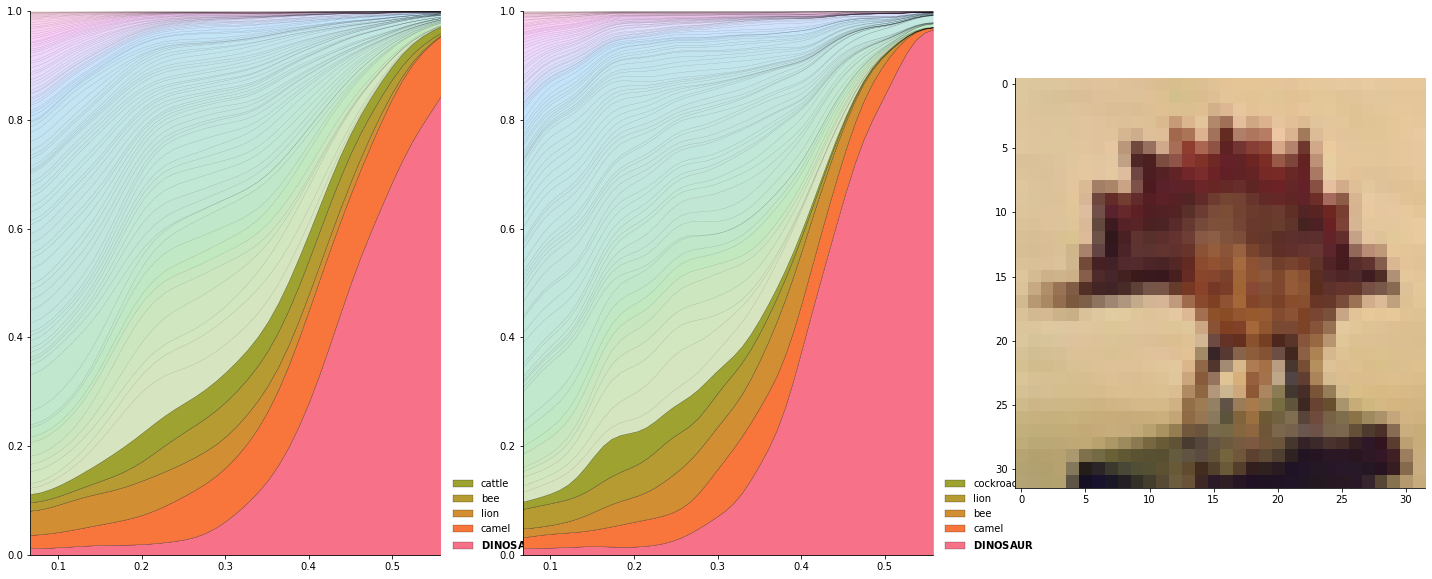

In [45]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)

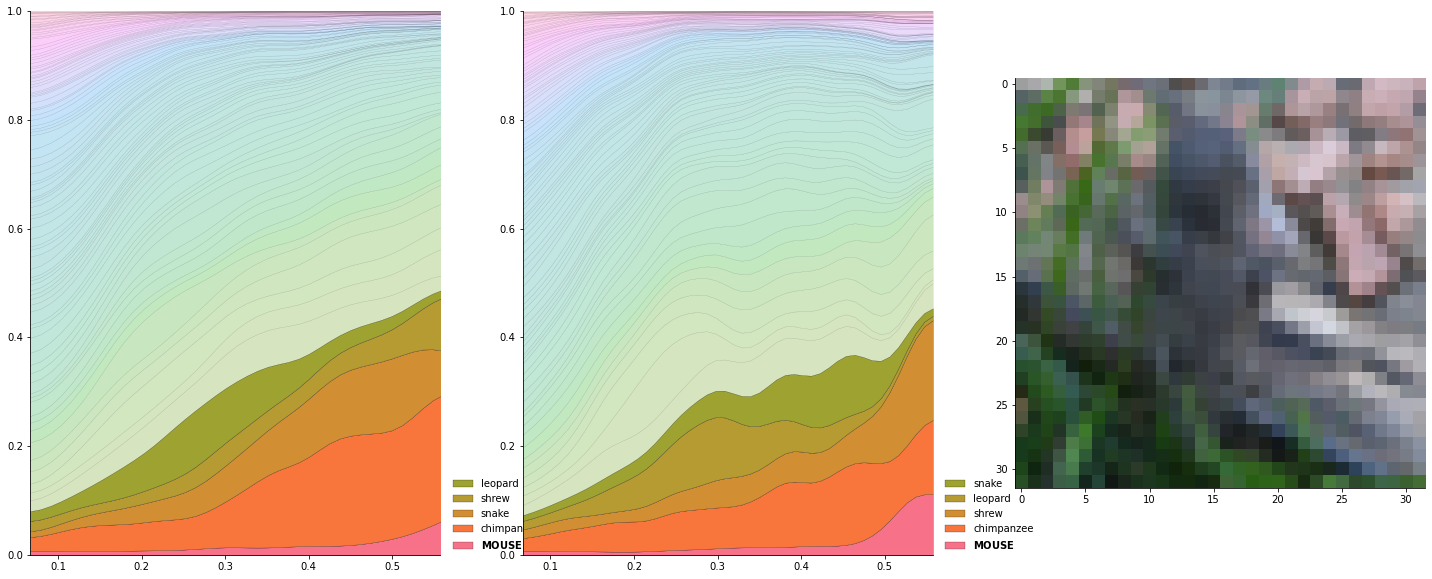

In [46]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)

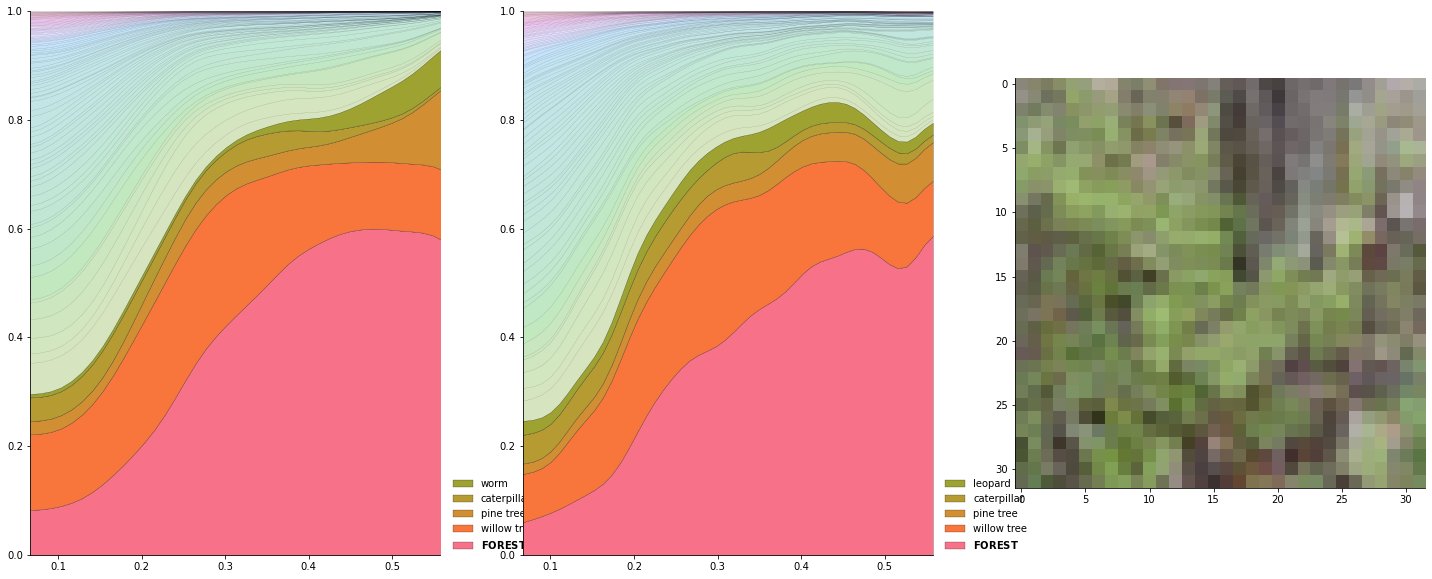

In [47]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)

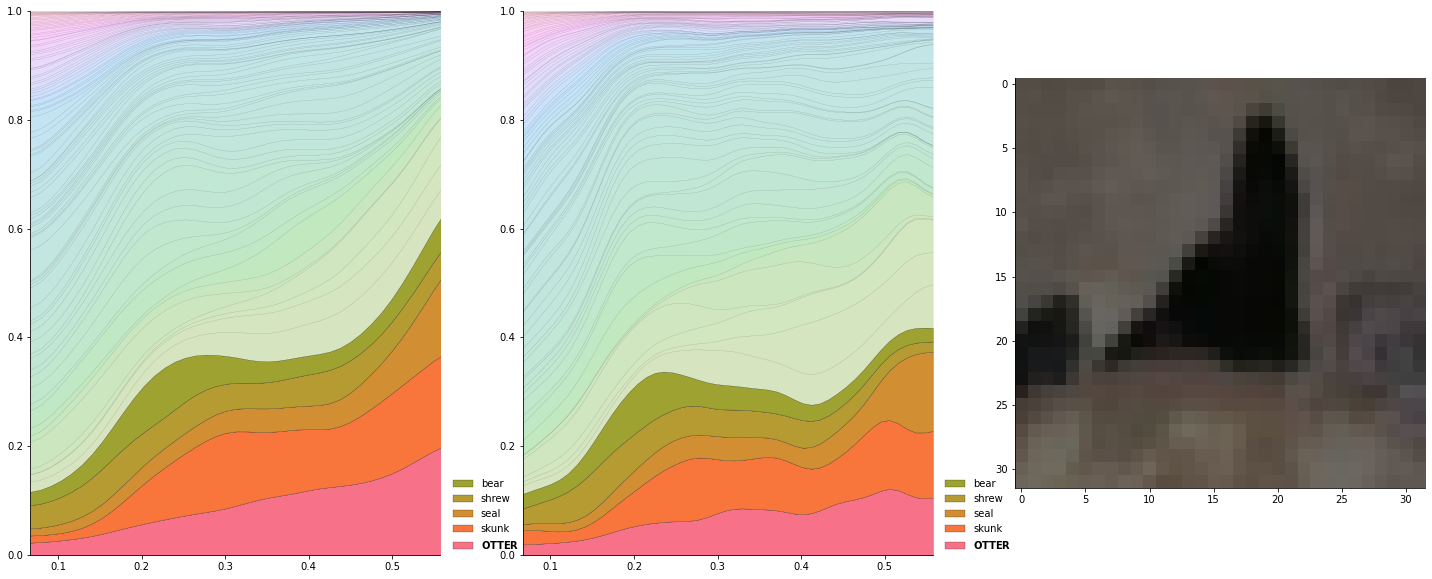

In [48]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)

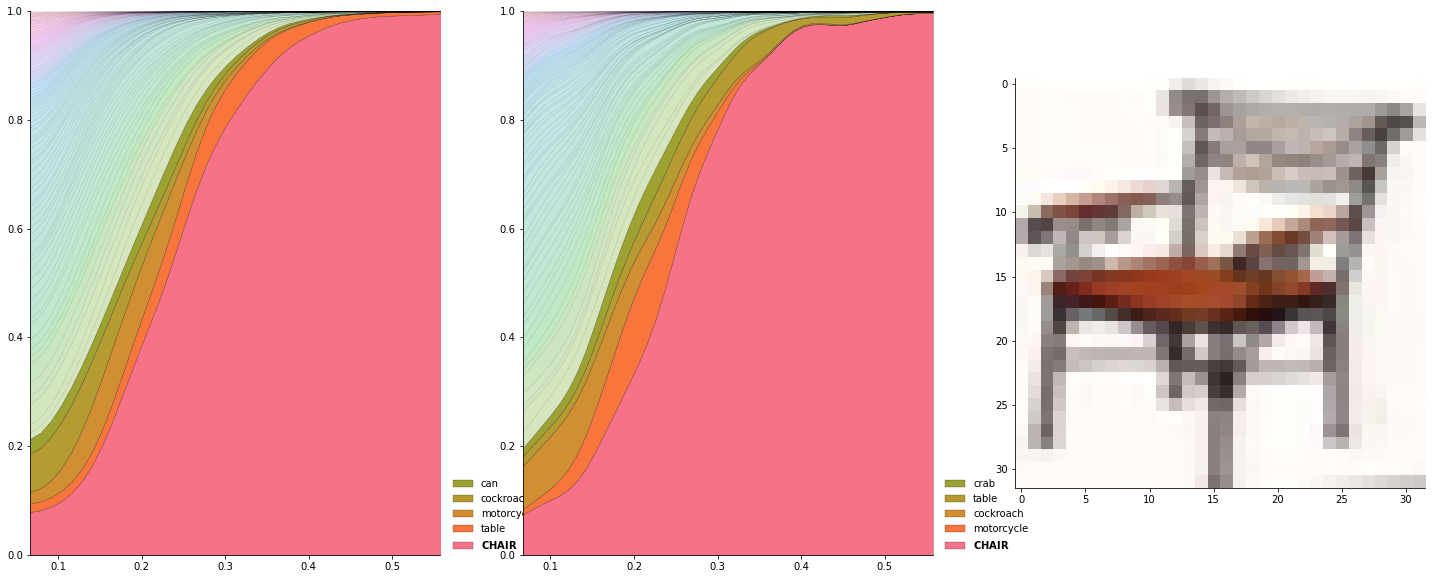

In [49]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)

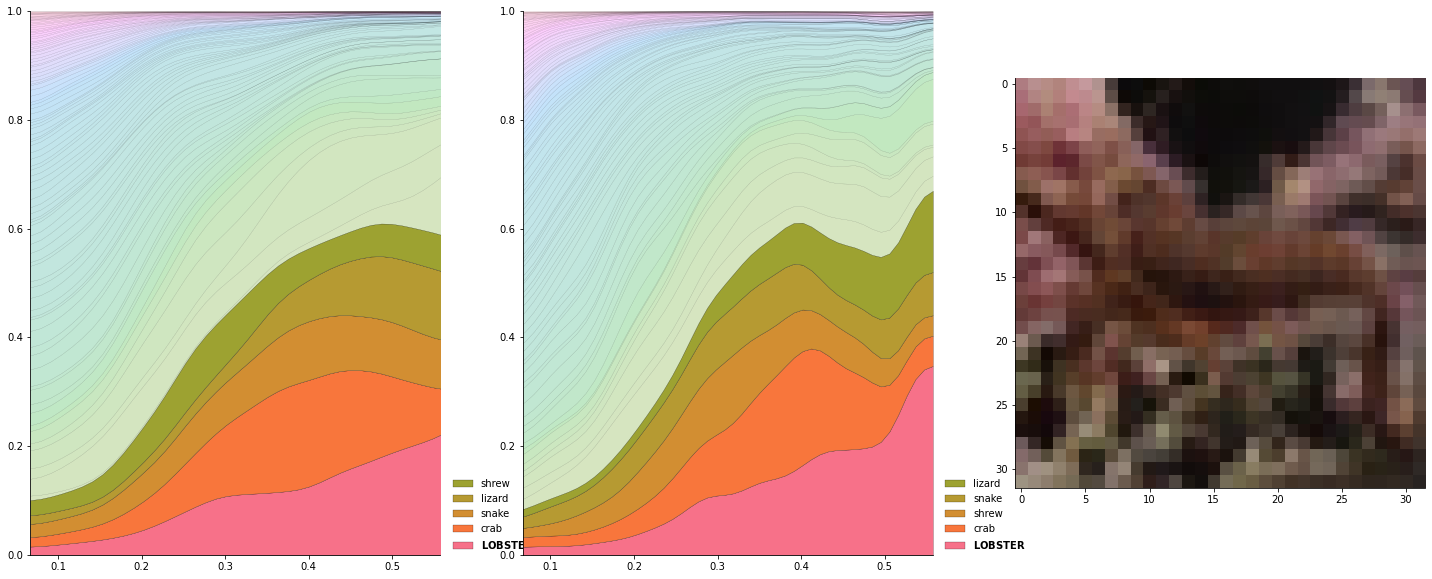

In [50]:

i = np.random.choice(10000)
plot_compare_two(i, G1, G2)